In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import seaborn as sns
import os
import sys
import pickle
from glob import glob

from gryffin import Gryffin

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, AckleyPathConstr, BraninConstr, HyperEllipsoidConstr, LevyConstr
from benchmark_functions import CatDejongConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)

ModuleNotFoundError: No module named 'gryffin'

In [42]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100, constr=True, contour=True):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    if contour:
        _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                     labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='golem')
        for param in surface.minima:
            x_min = param['params']
            ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='r', zorder=20)
    
    if constr:
        y_feas = np.array(surface.eval_constr(X))
        Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
        ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')

/home/riley/Software/anaconda3/envs/atlas/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Trying to register the cmap 'golem' which already exists.
  """
/home/riley/Software/anaconda3/envs/atlas/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Trying to register the cmap 'golem_r' which already exists.
  


In [32]:
from olympus.surfaces import Dejong
from benchmark_functions import Constr

class DummySurface1(Dejong, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        if x0 + x1 > 1.0:
            return False
        else:
            return True
        
        
class DummySurface2(Dejong, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        
        if x0**2 + (x1-1)**2 < 0.25:
            return False
        if (x0-1)**2 + x1**2 < 0.25:
            return False
        return True
    
    
class DummySurface3(Dejong, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if np.sum(np.sqrt(np.abs(Xi-0.5))) < 0.70:
            return False
        return True
    

class DummySurface4(Dejong, Constr):
    def is_feasible(self, Xi):
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        centers = [[0.25, 0.25],[0.25, 0.75],[0.5, 0.5], [0.75, 0.25],[0.75, 0.75]]
        
        for center in centers:
            if (x0 - center[0])**2 + (x1 - center[1])**2 < 0.015:
                return False
        return True

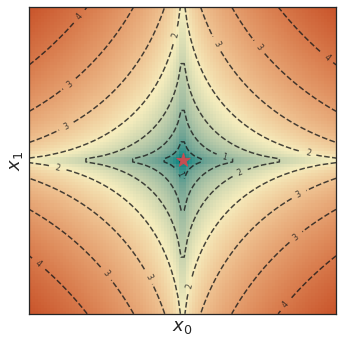

In [29]:
# OBJECTIVE FUNCTION f(x)

surface = DummySurface4()
n = 50

# random sampling
np.random.seed(26)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100, constr=False)

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

# ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
# ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
ax.set_xlabel(r'$x_0$',fontsize=18)
ax.set_ylabel(r'$x_1$',fontsize=18)

ax.tick_params(axis='x',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 
ax.tick_params(axis='y',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 

plt.tight_layout()
plt.savefig('objective_function.png', dpi=400)

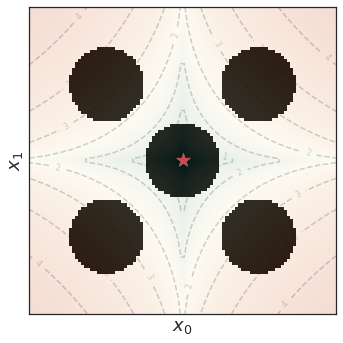

In [41]:
# CONSTRAINT FUNCTION c(x)

surface = DummySurface4()
n = 50

# random sampling
np.random.seed(26)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100, constr=True, contour=True)

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

# ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
# ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
ax.set_xlabel(r'$x_0$',fontsize=18)
ax.set_ylabel(r'$x_1$',fontsize=18)

ax.tick_params(axis='x',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 
ax.tick_params(axis='y',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 

plt.tight_layout()
plt.savefig('constraint_function.png', dpi=400)

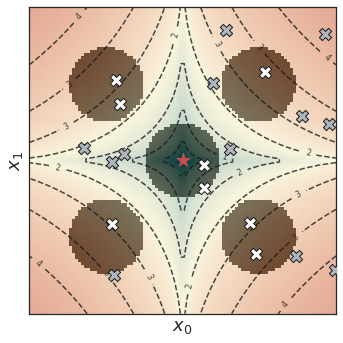

In [46]:
# COMBINED FUNCTIONS WITH MEASUREMENTS

surface = DummySurface4()
n = 20

# random sampling
np.random.seed(26)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100, constr=True, contour=True)

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=150, color='#adb5bd', edgecolor='k', zorder=10)
ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=150, color='white', edgecolor='k', zorder=10)
ax.set_xlabel(r'$x_0$',fontsize=18)
ax.set_ylabel(r'$x_1$',fontsize=18)

ax.tick_params(axis='x',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 
ax.tick_params(axis='y',which='both',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False) 

plt.tight_layout()
plt.savefig('combined_functions_w_measurements.png',dpi=400)

In [62]:
# build observations for Gryffin
observations = []
for x, o in zip(X, obj):
    d = {}
    d['x0'] = x[0]
    d['x1'] = x[1]
    d['obj'] = o
    observations.append(d)
    
observations[:5]

[{'x0': 0.8488176972685787, 'x1': 0.17889592492099848, 'obj': nan},
 {'x0': 0.05436321430643143,
  'x1': 0.36153844608822294,
  'obj': 3.2877079747302327},
 {'x0': 0.27540092860641197,
  'x1': 0.5300002248954253,
  'obj': 2.046387585940007},
 {'x0': 0.305918915735916, 'x1': 0.3044743591541431, 'obj': nan},
 {'x0': 0.1117412761755947,
  'x1': 0.24989901388011448,
  'obj': 3.5518863305150066}]

In [63]:
config = {
     "general": {
             "batches": 1,
             "parallel": False,
             "boosted":  False,
             "sampling_strategies": 1,
             "random_seed":42,
             "feas_approach": "fwa", 
             "feas_sensitivity": 1,
             "acquisition_optimizer": "genetic"
                },
    "model": {'num_epochs':  2 * 10**3,
              'learning_rate': 0.05,
              },
    "parameters": [
        {"name": "x0", "type": "continuous", "low": 0., "high": 1.},
        {"name": "x1", "type": "continuous", "low": 0., "high": 1.}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

gryffin = Gryffin(config_dict=config, silent=True)
#gryffin.recommend(observations=observations, sampling_strategies=[0])
gryffin.build_surrogate(observations)

In [64]:
N = 100
x0 = np.linspace(0, 1, N)
x1 = np.linspace(0, 1, N)
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

In [65]:
y = gryffin.get_feasibility_surrogate(df, threshold=None)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

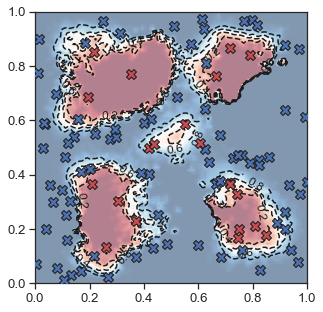

In [66]:
fig, ax = plt.subplots(figsize=(5,5))

_ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

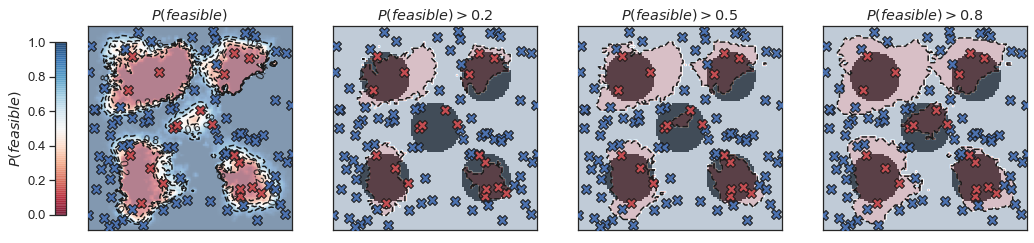

In [67]:
def plot_binary_surface(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)

    _ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
                 labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')



fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4), sharex=True, sharey=True)
  
# First plot with prob feasible
im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
axes[0].set_title('$P(feasible)$')

# color bar
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.0, 0.2, 0.01, 0.6])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')

# Plots with binary outcome
for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
    plot_binary_surface(ax, Y, threshold=t)
    
    ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')

    ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
    
    ax.set_title(f'$P(feasible) > {t}$')
    

# labels etc
_ = axes[0].set_yticks([])
_ = axes[0].set_xticks([])

In [68]:
def get_classification_model(surface_class, config, n=100, random_seed=42):
    
    surface = surface_class()

    # random sampling
    np.random.seed(random_seed)
    X = np.random.uniform(low=0, high=1, size=(n, 2))
    obj = np.array(surface.run_constr(X)).flatten()
    mask = np.isnan(obj)
    
    # build observations for Gryffin
    observations = []
    for x, o in zip(X, obj):
        d = {}
        d['x0'] = x[0]
        d['x1'] = x[1]
        d['obj'] = o
        observations.append(d)
        
    # run Gryffin
    N = 100
    x0 = np.linspace(0, 1, N)
    x1 = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0, x1)
    df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

    gryffin = Gryffin(config_dict=config, silent=True)
    #gryffin.recommend(observations=observations, sampling_strategies=[0])
    gryffin.build_surrogate(observations=observations)
    
    # get prob feas and constr
    y = gryffin.get_feasibility_surrogate(df, threshold=None)
    Y = np.reshape(y, newshape=np.shape(X0))
    y_constr = np.array(surface.eval_constr(df.to_numpy()))
    Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

    return X, X0, X1, Y, Y_constr, mask


def plot_binary_surface(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)

    _ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
                 labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')


def plot_row(axes, X, X0, X1, Y, Y_constr, mask):
  
    # First plot with prob feasible
    im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')

    axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  

    # Plots with binary outcome
    for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
        plot_binary_surface(ax, Y, threshold=t)
        ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
    return im

In [120]:
examples = {}

for i, S, rs in zip([0,1,2,3], 
                    [DummySurface1, DummySurface2, DummySurface3, DummySurface4], 
                    [0, 3, 4, 26]):
    print(f'processing surface No {i+1}...')
    X, X0, X1, Y, Y_constr, mask = get_classification_model(surface_class=S, n=50, config=config, random_seed=rs)
    
    examples[i] = {}
    examples[i]['X'] = X
    examples[i]['X0'] = X0
    examples[i]['X1'] = X1
    examples[i]['Y'] = Y
    examples[i]['Y_constr'] = Y_constr
    examples[i]['mask'] = mask

processing surface No 1...
processing surface No 2...
processing surface No 3...
processing surface No 4...


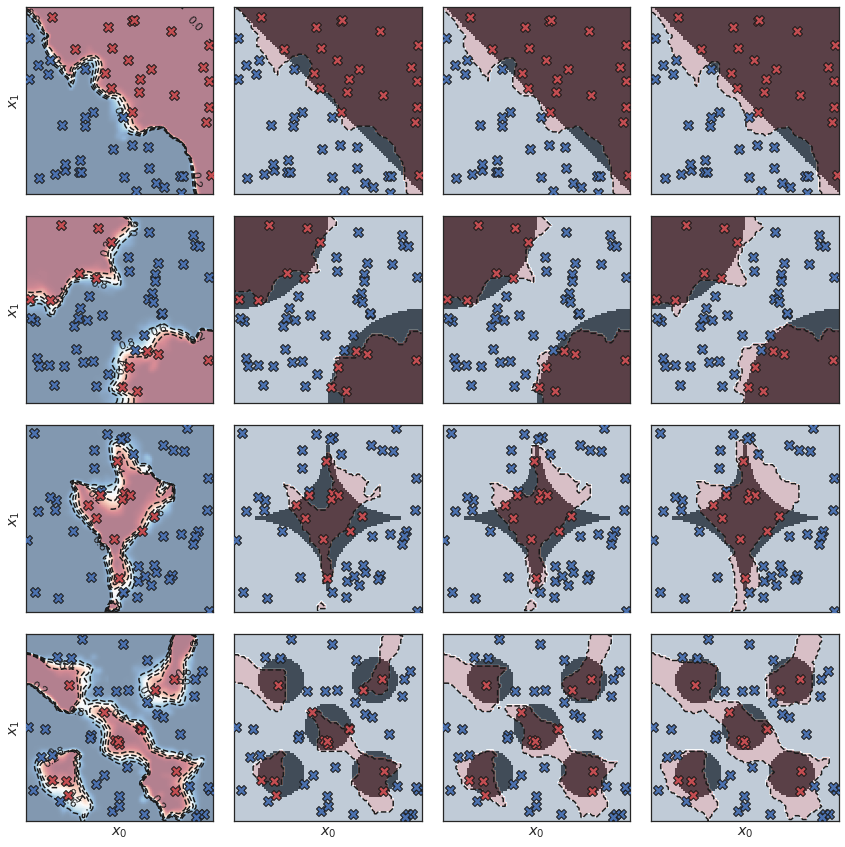

In [94]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True, sharey=True)

# example 1
i = 0
im0 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 2
i = 1
im1 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 3
i = 2
im2 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 4
i = 3
im3 = plot_row(axes[i, :], examples[i]['X'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])


# color bar
#fig.subplots_adjust(left=0.03)
#cbar_ax = fig.add_axes([0.0, 0.3, 0.01, 0.4])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax)
#_ = cbar_ax.set_ylabel('$P(feasible)$')
#cbar_ax.yaxis.set_ticks_position('left')
#cbar_ax.yaxis.set_label_position('left')

#fig.subplots_adjust(bottom=0.03)
#cbar_ax0 = fig.add_axes([0.046, 0.0, 0.2, 0.01])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax0, orientation='horizontal')
#_ = cbar_ax0.set_xlabel('$P(feasible)$')

#fig.subplots_adjust(top=1.05)
#cbar_ax = fig.add_axes([0.046, 1.0, 0.2, 0.01])  # [left, bottom, width, height]
#fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
#_ = cbar_ax.set_xlabel('$P(feasible)$')
#cbar_ax.xaxis.set_ticks_position('bottom')
#cbar_ax.xaxis.set_label_position('top')

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    axes[j, 0].set_ylabel('$x_1$')
    

#axes[0,0].set_title('$P(feasible)$')
#axes[0,1].set_title('$P(feasible) > 0.2$')
#axes[0,2].set_title('$P(feasible) > 0.5$')
#axes[0,3].set_title('$P(feasible) > 0.8$')

plt.tight_layout()
#fig.savefig('continuous_examples.pdf', bbox_inches='tight')

## Categorical

In [152]:
def plot_constr_surface_cat(surface, ax=None, mark_min=False, cbar=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(surface.num_opts)
    Z = np.zeros((surface.num_opts, surface.num_opts))
    Z_feas = np.empty((surface.num_opts, surface.num_opts))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            #feas_bool = surface.eval_constr({'x0': x[0], 'x1': x[1]})
            feas_bool = surface.eval_constr(x)
            Z[y_index, x_index] = loss_value
            Z_feas[y_index, x_index] = feas_bool
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    mappable = ax.imshow(Z, origin='lower', cmap = plt.get_cmap('golem'))
    _ = ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

In [153]:
class CatDummySurface1(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if x0 + x1 > 19:
            return False
        return True
    
    
class CatDummySurface2(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if x0**2 + (x1-20)**2 < 110:
            return False
        if (x0-20)**2 + x1**2 < 110:
            return False
        return True
    
    
class CatDummySurface3(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        if np.sum(np.sqrt(np.abs(Xi-10))) < 3:
            return False

        return True
    
class CatDummySurface4(CatDejongConstr):    
    def is_feasible(self, sample):
        Xi = self.str2array(sample)
        x0 = Xi[0]
        x1 = Xi[1]
        Xi = np.array(Xi)
        
        centers = [[5, 5],[5, 15],[10, 10], [15, 5],[15, 15]]
        
        for center in centers:
            if (x0 - center[0])**2 + (x1 - center[1])**2 < 6:
                return False
        return True

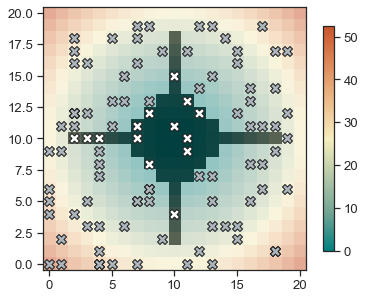

In [154]:
# plot surface
surface = CatDummySurface3()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5,5))
plot_constr_surface_cat(surface, ax=ax, cbar=True)

# random sampling
np.random.seed(15)
n = 100
X_int = np.random.choice(range(20), size=(n, 2))

obj = []
X = []
for xi in X_int:
    param = {'x0':f'x_{xi[0]}', 'x1':f'x_{xi[1]}'}
    o = surface.run_constr(xi)
    X.append([f'x_{xi[0]}', f'x_{xi[1]}'])
    obj.append(o)


mask = np.isnan(obj)
X_feas = X_int[~mask]
X_infs = X_int[mask]

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='white', edgecolor='k', zorder=10)

plt.tight_layout()

In [155]:
# build observations for Gryffin
observations = []
for x, o in zip(X, obj):
    d = {}
    d['x0'] = x[0]
    d['x1'] = x[1]
    d['obj'] = o
    observations.append(d)
    
observations[:5]

[{'x0': 'x_8', 'x1': 'x_12', 'obj': nan},
 {'x0': 'x_5', 'x1': 'x_0', 'obj': 32.768},
 {'x0': 'x_7', 'x1': 'x_11', 'obj': nan},
 {'x0': 'x_15', 'x1': 'x_17', 'obj': 19.398656000000003},
 {'x0': 'x_13', 'x1': 'x_0', 'obj': 28.573696}]

In [156]:
cat_details_naive = {k:None for k in [f'x_{i}' for i in range(21)]}
cat_details_wdesc = {k:[v] for v,k in enumerate([f'x_{i}' for i in range(21)])}

config = {
     "general": {
             "num_cpus": 1,
             "auto_desc_gen": False,
             "batches": 1,
             "caching": True,
             "boosted":  False,
             "sampling_strategies": 1,
             "random_seed":42,
             "feas_approach": "fca", 
             "feas_param": 0.5,
             "acquisition_optimizer": "genetic"
                },
    "model": {'num_epochs':  2 * 10**3,
              'learning_rate': 0.05,
              },
    "parameters": [
         {"name": "x0", "type": "categorical", "category_details": cat_details_wdesc},
         {"name": "x1", "type": "categorical", "category_details": cat_details_wdesc}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

gryffin = Gryffin(config_dict=config, silent=False)
#gryffin.recommend(observations=observations, sampling_strategies=[0])
gryffin.build_surrogate(observations)

⠧ Training the Bayesian neural network...

Bayesian neural network trained in 11.1 s

─────────────────────────────────── Summary ────────────────────────────────────

Memory usage: 1 GB, 1142 MB, 226 kB

===================================== End ======================================

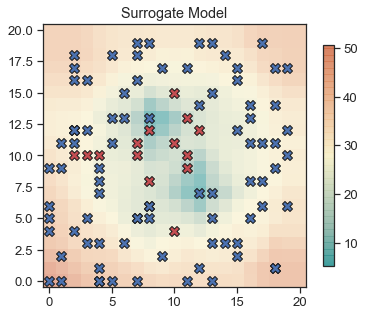

In [157]:
x0 = [f'x_{i}' for i in range(21)]
x1 = [f'x_{i}' for i in range(21)]
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})


# -------
# compute
# -------
y = gryffin.get_regression_surrogate(df)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

# ----
# plot
# ----
fig, ax = plt.subplots(figsize=(5.5, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax.imshow(Y, origin='lower', cmap='golem', alpha=0.5)
cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

ax.set_title('Surrogate Model')
plt.tight_layout()

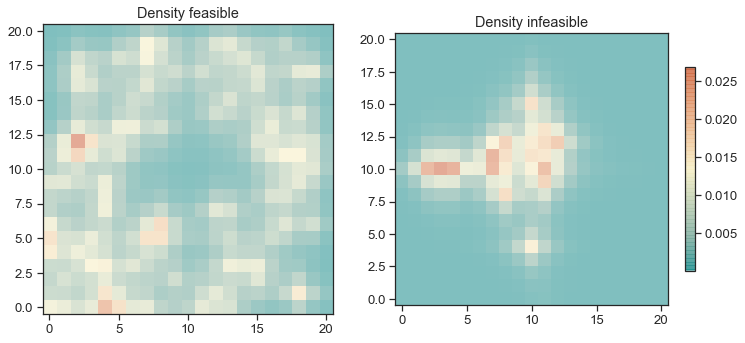

In [158]:
x0 = [f'x_{i}' for i in range(21)]
x1 = [f'x_{i}' for i in range(21)]
X0, X1 = np.meshgrid(x0, x1)
df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})


# -------
# compute
# -------
y = gryffin.get_kernel_density_estimate(df, separate_kwn_ukwn=True)
Y_0 = np.reshape(y.T[0], newshape=np.shape(X0))
Y_1 = np.reshape(y.T[1], newshape=np.shape(X0))

# ----
# plot
# ----
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax1.imshow(Y_0, origin='lower', cmap='golem', alpha=0.5)
mappable = ax2.imshow(Y_1, origin='lower', cmap='golem', alpha=0.5)

cbar = plt.colorbar(mappable=mappable, ax=ax2, shrink=0.7)

ax1.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10, alpha=0)
ax2.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10, alpha=0)

ax1.set_title('Density feasible')
ax2.set_title('Density infeasible')
plt.tight_layout()

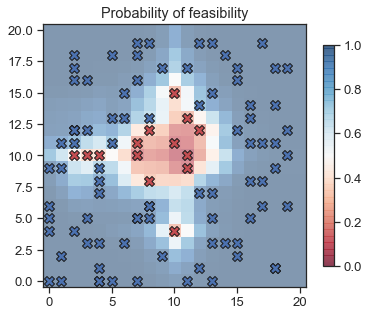

In [159]:
# -------
# compute
# -------
y = gryffin.get_feasibility_surrogate(df, threshold=None)
Y = np.reshape(y, newshape=np.shape(X0))

y_constr = np.array(surface.eval_constr(df.to_numpy()))
Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

# ----
# plot
# ----
fig, ax = plt.subplots(figsize=(5.5, 5))

xlims = [0,20]
ylims = [0,20]

mappable = ax.imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

ax.scatter(X_int[~mask].T[0], X_int[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
ax.scatter(X_int[mask].T[0], X_int[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

ax.set_title('Probability of feasibility')
plt.tight_layout()

In [160]:
def get_classification_model_for_cat(surface_class, config, n=100, random_seed=42):
    
    surface = surface_class()

    # random sampling
    
    # random sampling
    np.random.seed(15)
    n = 100
    X_int = np.random.choice(range(20), size=(n, 2))
    
    obj = []
    X = []
    for xi in X_int:
        param = {'x0':f'x_{xi[0]}', 'x1':f'x_{xi[1]}'}
        o = surface.run_constr(xi)
        X.append([f'x_{xi[0]}', f'x_{xi[1]}'])
        obj.append(o)
        
    mask = np.isnan(obj)
    
    # build observations for Gryffin
    observations = []
    for x, o in zip(X, obj):
        d = {}
        d['x0'] = x[0]
        d['x1'] = x[1]
        d['obj'] = o
        observations.append(d)
        
    # run Gryffin    
    gryffin = Gryffin(config_dict=config, silent=True)
    gryffin.build_surrogate(observations)

    # get model
    x0 = [f'x_{i}' for i in range(21)]
    x1 = [f'x_{i}' for i in range(21)]
    X0, X1 = np.meshgrid(x0, x1)
    df = pd.DataFrame({'x0': X0.flatten(), 'x1': X1.flatten()})

    y = gryffin.get_feasibility_surrogate(df)
    Y = np.reshape(y, newshape=np.shape(X0))

    y_constr = np.array(surface.eval_constr(df.to_numpy()))
    Y_constr = np.reshape(y_constr, newshape=np.shape(X0))

    return X, X_int, X0, X1, Y, Y_constr, mask


def plot_binary_surface_cat(ax, Y, threshold=0.5):

    Y_binary = np.where(Y > threshold, 1.0, Y)  # if Y>0.5 return 1.0 else Y
    Y_binary = np.where(Y_binary <= threshold, 0.0, Y_binary)
    
    mappable = ax.imshow(Y_binary, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
    #cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.7)

    #_ = plot_contour(ax, X0, X1, Y_binary, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=False, 
    #             labels_fs=12, labels_fmt='%.2f', n_contour_lines=0, contour_alpha=1, cbar=False, cmap='RdBu')


def plot_row_cat(axes, X, X0, X1, Y, Y_constr, mask):
  
    # First plot with prob feasible
    #im = plot_contour(axes[0], X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
    #             labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
    mappable = axes[0].imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)

    axes[0].scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
    axes[0].scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  

    # Plots with binary outcome
    for ax, t in zip(axes[1:], [0.20, 0.5, 0.8]):
        plot_binary_surface_cat(ax, Y, threshold=t)
        ax.imshow(Y_constr, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
    return im

In [161]:
examples = {}

for i, S, rs in zip([0,1,2,3], 
                    [CatDummySurface1, CatDummySurface2, CatDummySurface3, CatDummySurface4], 
                    [0, 42, 8, 15]):
    print(f'processing surface No {i+1}...')
    X, X_int, X0, X1, Y, Y_constr, mask = get_classification_model_for_cat(surface_class=S, n=50, config=config, random_seed=rs)
    
    examples[i] = {}
    examples[i]['X'] = X
    examples[i]['X_int'] = X_int
    examples[i]['X0'] = X0
    examples[i]['X1'] = X1
    examples[i]['Y'] = Y
    examples[i]['Y_constr'] = Y_constr
    examples[i]['mask'] = mask

processing surface No 1...
processing surface No 2...
processing surface No 3...
processing surface No 4...


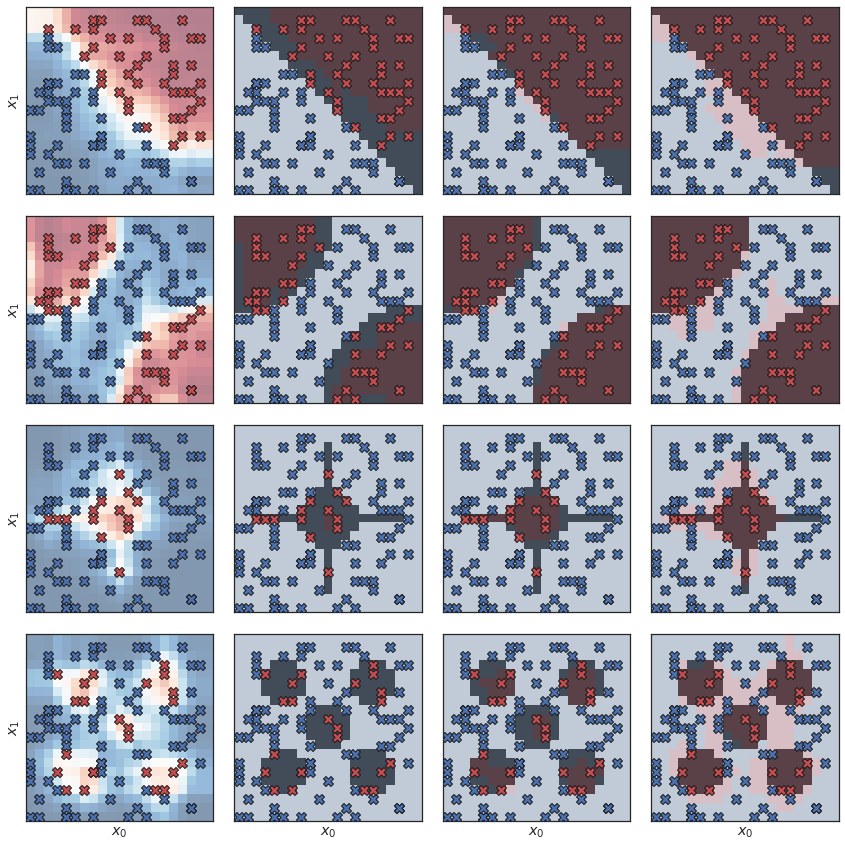

In [163]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharex=True, sharey=True)

# example 1
i = 0
im0 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 2
i = 1
im1 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 3
i = 2
im2 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# example 4
i = 3
im3 = plot_row_cat(axes[i, :], examples[i]['X_int'], examples[i]['X0'], examples[i]['X1'], examples[i]['Y'], 
         examples[i]['Y_constr'], examples[i]['mask'])

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    axes[j, 0].set_ylabel('$x_1$')
    

#axes[0,0].set_title('$P(feasible)$')
#axes[0,1].set_title('$P(feasible) > 0.2$')
#axes[0,2].set_title('$P(feasible) > 0.5$')
#axes[0,3].set_title('$P(feasible) > 0.8$')

plt.tight_layout()
#fig.savefig('classification_examples.pdf', bbox_inches='tight')

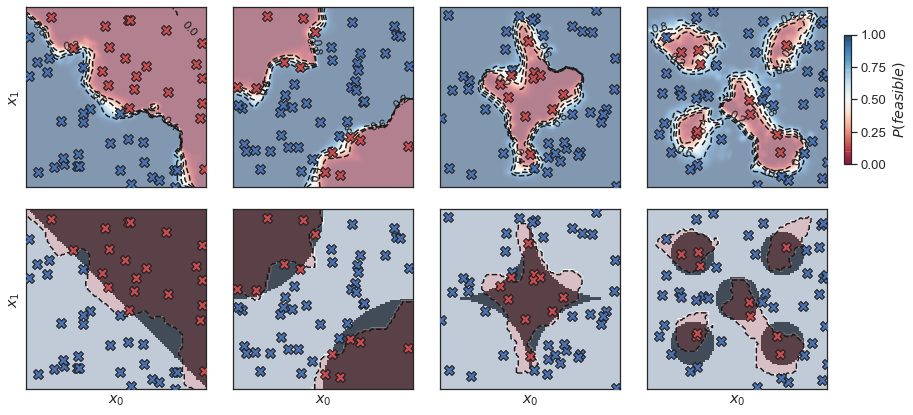

In [145]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)


def plot_classification_w_scatter(ax, i, examples, thres=None):
    Y = examples[i]['Y']
    X = examples[i]['X']
    X0 = examples[i]['X0']
    X1 = examples[i]['X1']
    Y_constr = examples[i]['Y_constr']
    mask = examples[i]['mask']
    if thres is None:
        im = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
    else:
        plot_binary_surface(ax, Y, threshold=thres)
        ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)

# row 1
plot_classification_w_scatter(ax=axes[0,0], i=0, examples=examples)
plot_classification_w_scatter(ax=axes[0,1], i=1, examples=examples)
plot_classification_w_scatter(ax=axes[0,2], i=2, examples=examples)
plot_classification_w_scatter(ax=axes[0,3], i=3, examples=examples)

# row 2
plot_classification_w_scatter(ax=axes[1,0], i=0, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,1], i=1, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,2], i=2, examples=examples, thres=0.5)
plot_classification_w_scatter(ax=axes[1,3], i=3, examples=examples, thres=0.5)

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    if j in [0,1]:
        axes[j, 0].set_ylabel('$x_1$')
    
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.99, 0.6, 0.008, 0.3])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('right')

plt.tight_layout()
fig.savefig('continuous_examples.pdf', bbox_inches='tight')

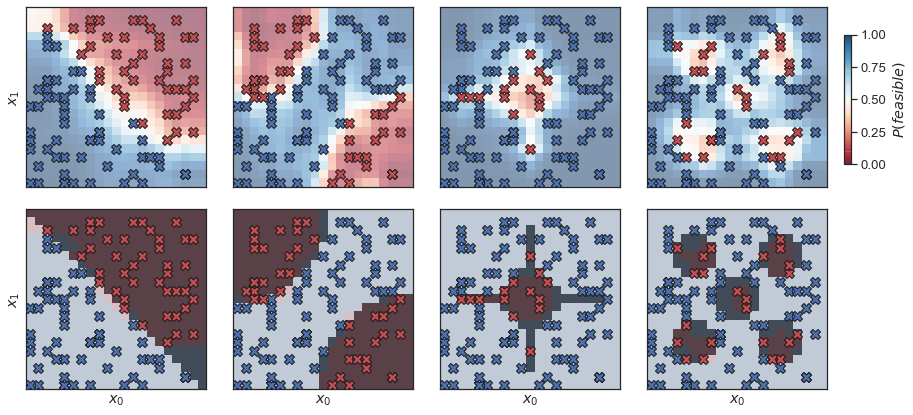

In [171]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=True, sharey=True)


def plot_classification_w_scatter(ax, i, examples, thres=None, categorical=False):
    Y = examples[i]['Y']
    X = examples[i]['X_int']
    X0 = examples[i]['X0']
    X1 = examples[i]['X1']
    Y_constr = examples[i]['Y_constr']
    mask = examples[i]['mask']
    if thres is None:
        if categorical is False:
            im = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=12, labels_fmt='%.1f', n_contour_lines=5, contour_alpha=1, cbar=False, cmap='RdBu')
        else:
            mappable = ax.imshow(Y, origin='lower', cmap='RdBu', alpha=0.5, vmin=0, vmax=1)
        
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)  
    else:
        if categorical is False:
            plot_binary_surface(ax, Y, threshold=thres)
            ax.imshow(Y_constr, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        else:
            plot_binary_surface_cat(ax, Y, threshold=thres)
            ax.imshow(Y_constr, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
        
        ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='b', edgecolor='k', zorder=10)
        ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='r', edgecolor='k', zorder=10)
        
# row 1        
plot_classification_w_scatter(ax=axes[0,0], i=0, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,1], i=1, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,2], i=2, examples=examples, categorical=True)
plot_classification_w_scatter(ax=axes[0,3], i=3, examples=examples, categorical=True)

# row 2
plot_classification_w_scatter(ax=axes[1,0], i=0, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,1], i=1, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,2], i=2, examples=examples, thres=0.5, categorical=True)
plot_classification_w_scatter(ax=axes[1,3], i=3, examples=examples, thres=0.5, categorical=True)

# labels etc
_ = axes[0,0].set_yticks([])
_ = axes[0,0].set_xticks([])

for j in [0,1,2,3]:
    axes[-1, j].set_xlabel('$x_0$')
    if j in [0,1]:
        axes[j, 0].set_ylabel('$x_1$')
    
fig.subplots_adjust(left=0.03)
cbar_ax = fig.add_axes([0.99, 0.6, 0.008, 0.3])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('$P(feasible)$')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('right')

plt.tight_layout()
fig.savefig('categorical_examples.pdf', bbox_inches='tight')